Shape: (309215, 34)
Columns:
 Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'Response', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DataValueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 'StratificationCategory2',
       'Stratification2', 'StratificationCategory3', 'Stratification3',
       'Geolocation', 'LocationID', 'TopicID', 'QuestionID', 'ResponseID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1',
       'StratificationCategoryID2', 'StratificationID2',
       'StratificationCategoryID3', 'StratificationID3'],
      dtype='object')
   YearStart  YearEnd LocationAbbr LocationDesc DataSource     Topic  \
0       2019     2019           AR     Arkansas      BRFSS  Diabetes   
1       2019     2019           ID        Idaho      BRFSS  Diabetes   
2       2019     2019      

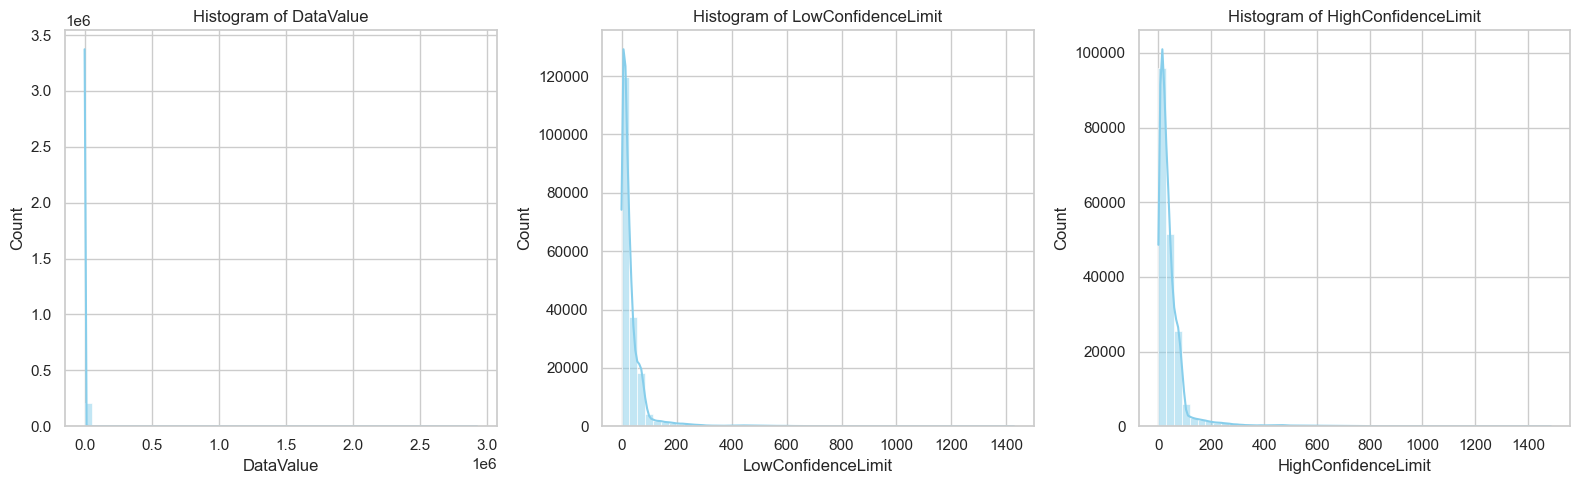

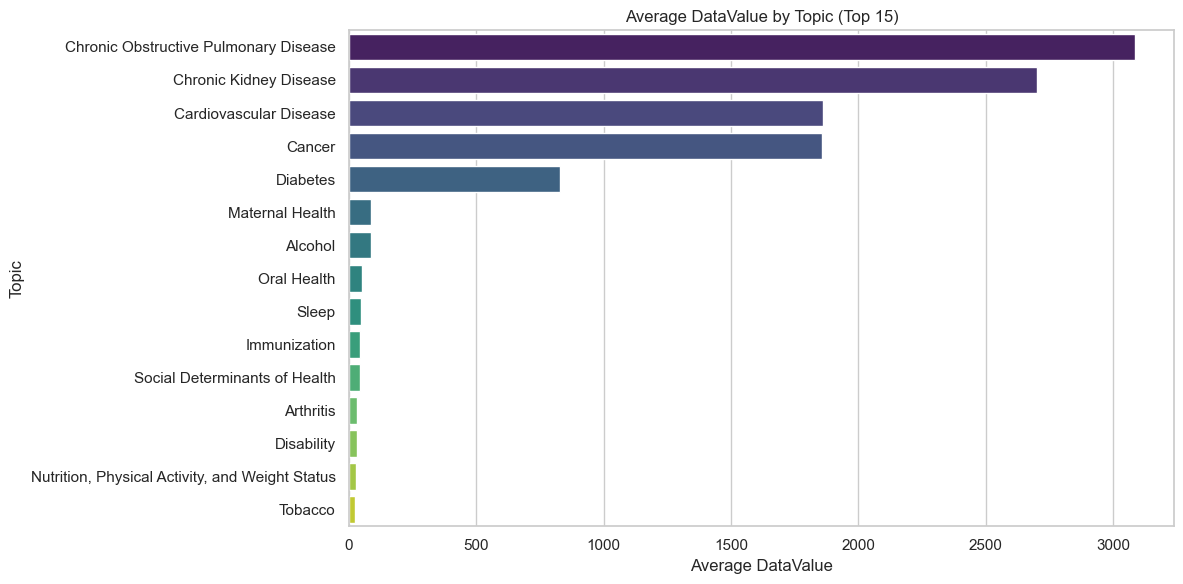

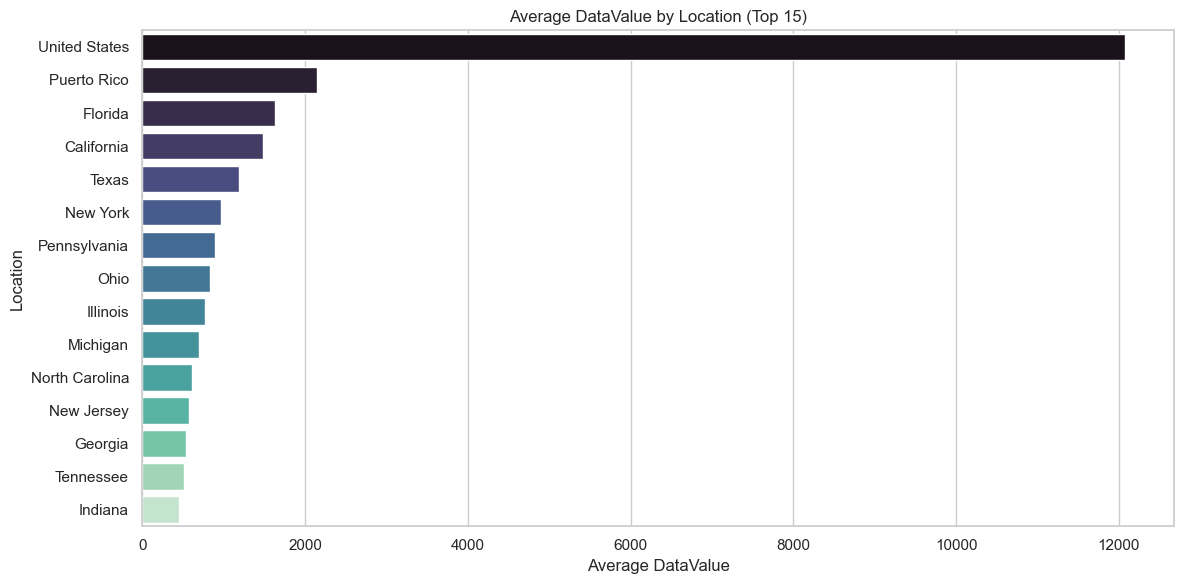

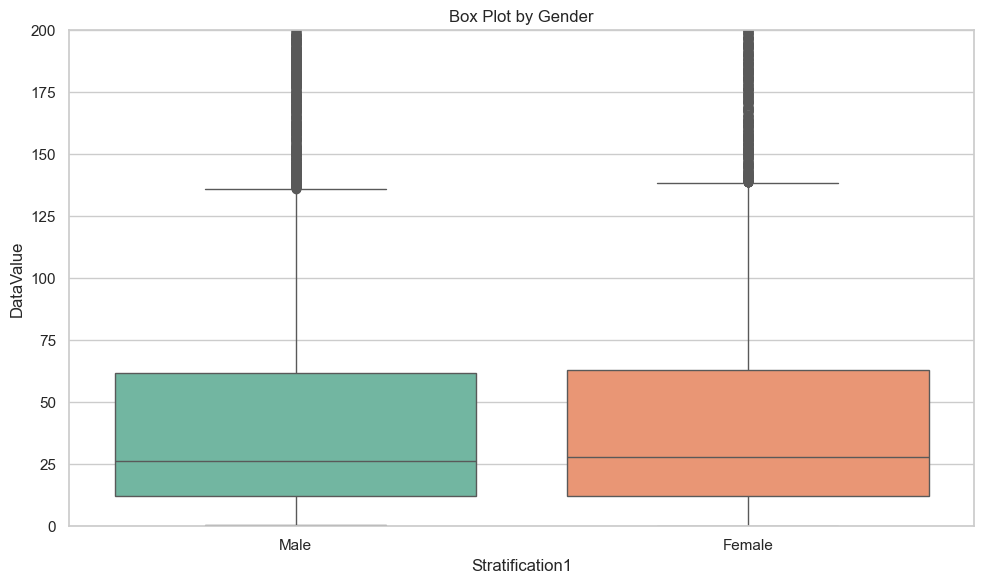

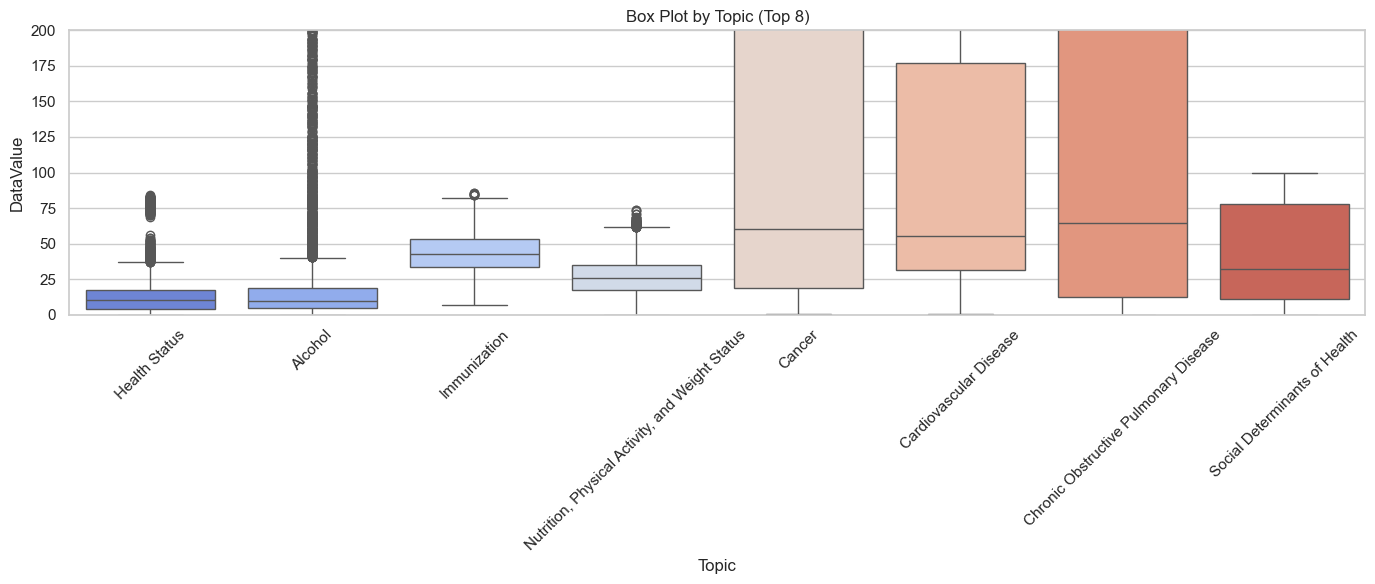

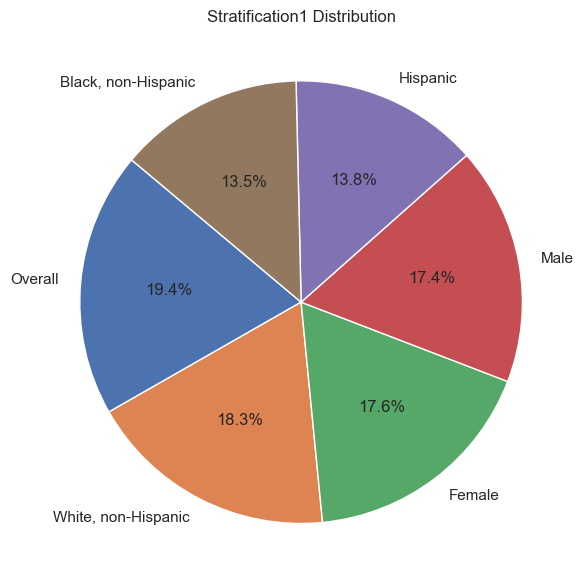

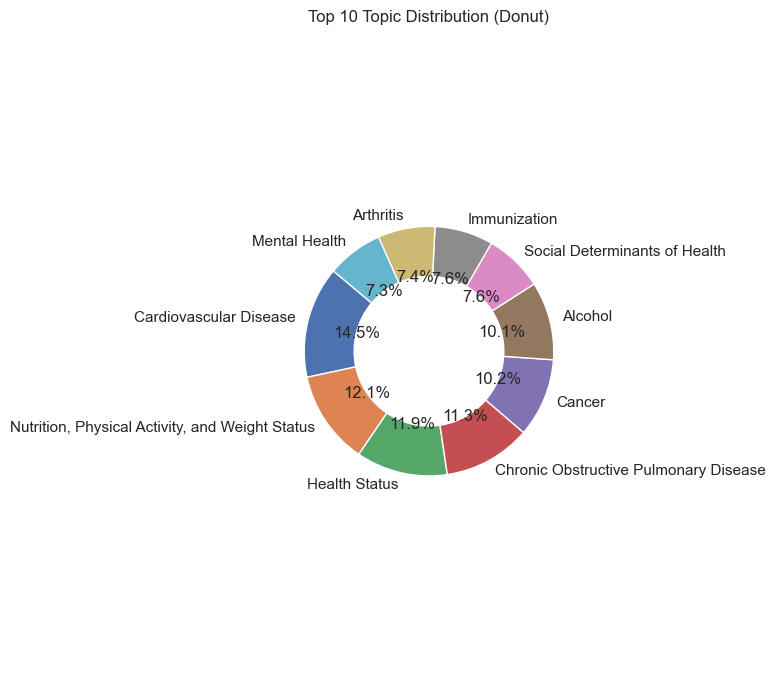

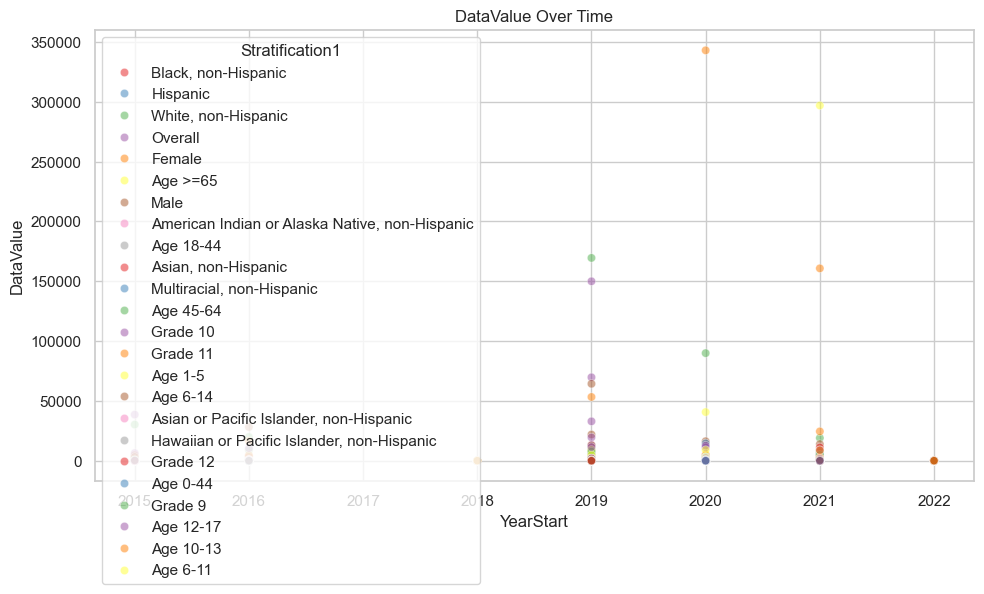

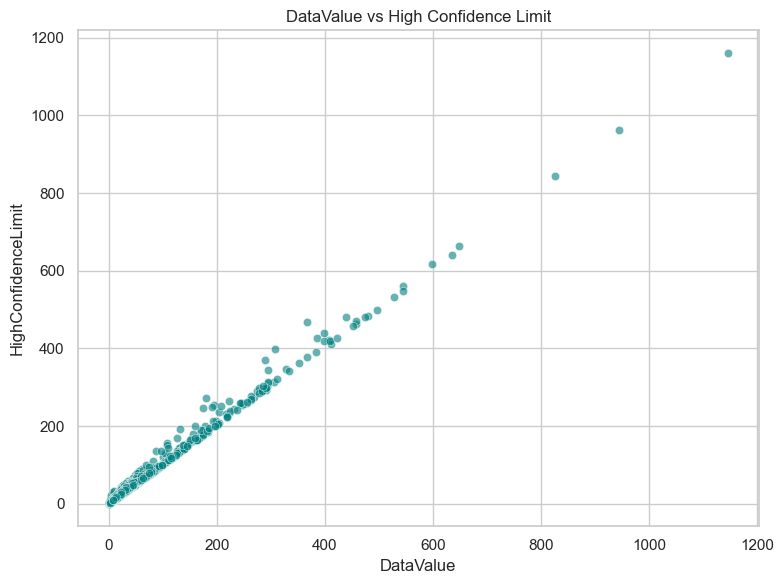

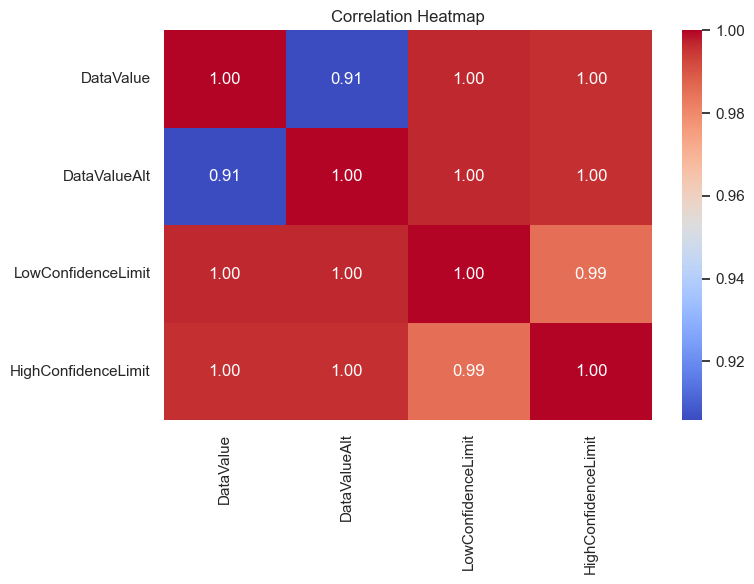

🔹 Z-Test (Male vs Female):
Z-Statistic: -1.304
P-Value: 0.1923

🔹 T-Test (California vs Overall):
T-Statistic: 3.016
P-Value: 0.0026

🔹 F-Test (Alcohol vs Tobacco variance):
F-Statistic: 3341.630
P-Value: 0.0000

📌 Interpretation of Z-Test (Male vs Female):
❌ Result is not statistically significant (p = 0.1923 ≥ 0.05)

📌 Interpretation of T-Test (California vs Overall):
✅ Result is statistically significant (p = 0.0026 < 0.05)

📌 Interpretation of F-Test (Alcohol vs Tobacco):
✅ Result is statistically significant (p = 0.0000 < 0.05)
🔹 Model Evaluation:
RMSE: 16583.91
R² Score: 0.024


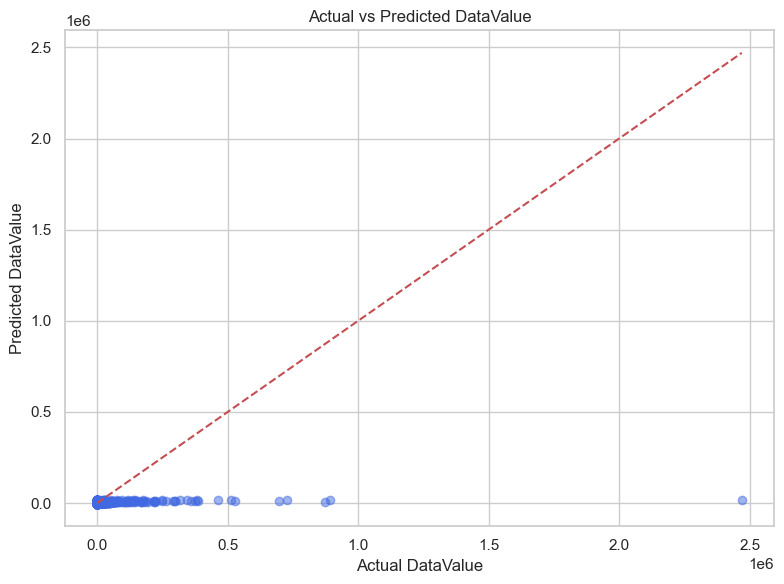

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
df = pd.read_csv(r"C:\Users\gottam dhanush\Downloads\U.S._Chronic_Disease_Indicators.csv")

# 3.1 Overview
print("Shape:", df.shape)
print("Columns:\n", df.columns)
print(df.head())

# 3.2 Cleaning and Preprocessing
df = df.drop(columns=[
    'StratificationCategory2', 'Stratification2',
    'StratificationCategory3', 'Stratification3',
    'StratificationCategoryID2', 'StratificationID2',
    'StratificationCategoryID3', 'StratificationID3',
    'Response', 'ResponseID'
], errors='ignore')

df = df.dropna(subset=['DataValue'])  # Remove rows without DataValue

# 3.3 Summary Statistics
print("\nSummary Statistics:\n", df.describe(include='all'))
print("\nData Types:\n", df.dtypes)
#detailed analysis on dataset
sns.set(style="whitegrid")
numeric_cols = ['DataValue', 'LowConfidenceLimit', 'HighConfidenceLimit']

plt.figure(figsize=(16, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()
# Average DataValue by Topic
plt.figure(figsize=(12, 6))
topic_avg = df.groupby("Topic")["DataValue"].mean().sort_values(ascending=False).head(15)
sns.barplot(x=topic_avg.values, y=topic_avg.index, palette="viridis")
plt.title("Average DataValue by Topic (Top 15)")
plt.xlabel("Average DataValue")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

# Average DataValue by Location
plt.figure(figsize=(12, 6))
location_avg = df.groupby("LocationDesc")["DataValue"].mean().sort_values(ascending=False).head(15)
sns.barplot(x=location_avg.values, y=location_avg.index, palette="mako")
plt.title("Average DataValue by Location (Top 15)")
plt.xlabel("Average DataValue")
plt.ylabel("Location")
plt.tight_layout()
plt.show()
#box plot 
# By Gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df["Stratification1"].isin(["Male", "Female"])],
            x="Stratification1", y="DataValue", palette="Set2")
plt.title("Box Plot by Gender")
plt.ylim(0, 200)
plt.tight_layout()
plt.show()

# By Top 8 Topics
plt.figure(figsize=(14, 6))
top_topics = df['Topic'].value_counts().head(8).index
sns.boxplot(data=df[df["Topic"].isin(top_topics)],
            x="Topic", y="DataValue", palette="coolwarm")
plt.title("Box Plot by Topic (Top 8)")
plt.xticks(rotation=45)
plt.ylim(0, 200)
plt.tight_layout()
plt.show()
# Pie Chart: Gender/Demographics
strat_counts = df['Stratification1'].value_counts().head(6)
plt.figure(figsize=(6, 6))
plt.pie(strat_counts, labels=strat_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Stratification1 Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Donut Chart: Topics
topic_counts = df['Topic'].value_counts().head(10)
plt.figure(figsize=(7, 7))
plt.pie(topic_counts, labels=topic_counts.index, startangle=140,
        autopct='%1.1f%%', wedgeprops={'width': 0.4})
plt.title("Top 10 Topic Distribution (Donut)")
plt.axis('equal')
plt.tight_layout()
plt.show()
# Scatter: DataValue vs YearStart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(3000), x='YearStart', y='DataValue',
                hue='Stratification1', alpha=0.5, palette='Set1')
plt.title('DataValue Over Time')
plt.tight_layout()
plt.show()

# Scatter: DataValue vs HighConfidenceLimit
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df.sample(3000), x='DataValue', y='HighConfidenceLimit', alpha=0.6, color='teal')
plt.title('DataValue vs High Confidence Limit')
plt.tight_layout()
plt.show()
# Correlation Heatmap
numeric_cols = ['DataValue', 'DataValueAlt', 'LowConfidenceLimit', 'HighConfidenceLimit']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()
#Z test
male = df[df["Stratification1"] == "Male"]["DataValue"].dropna()
female = df[df["Stratification1"] == "Female"]["DataValue"].dropna()

# Take samples (1000 each)
male_sample = male.sample(1000, random_state=1)
female_sample = female.sample(1000, random_state=1)

# Perform Z-Test (as a T-Test for large samples)
z_stat, p_val_z = stats.ttest_ind(male_sample, female_sample)
print("🔹 Z-Test (Male vs Female):")
print(f"Z-Statistic: {z_stat:.3f}")
print(f"P-Value: {p_val_z:.4f}")
#T Test
# California values
california = df[df["LocationDesc"] == "California"]["DataValue"].dropna()
overall = df["DataValue"].dropna().sample(1000, random_state=2)

# Perform T-Test
t_stat, p_val_t = stats.ttest_ind(california, overall)
print("\n🔹 T-Test (California vs Overall):")
print(f"T-Statistic: {t_stat:.3f}")
print(f"P-Value: {p_val_t:.4f}")
#P test
# Alcohol and Tobacco Data
alcohol = df[df["Topic"] == "Alcohol"]["DataValue"].dropna()
tobacco = df[df["Topic"] == "Tobacco"]["DataValue"].dropna()

# Perform F-Test
f_stat = np.var(alcohol, ddof=1) / np.var(tobacco, ddof=1)
df1, df2 = len(alcohol)-1, len(tobacco)-1
p_val_f = 1 - stats.f.cdf(f_stat, df1, df2)

print("\n🔹 F-Test (Alcohol vs Tobacco variance):")
print(f"F-Statistic: {f_stat:.3f}")
print(f"P-Value: {p_val_f:.4f}")
def interpret_result(test_name, p_val, alpha=0.05):
    print(f"\n📌 Interpretation of {test_name}:")
    if p_val < alpha:
        print(f"✅ Result is statistically significant (p = {p_val:.4f} < {alpha})")
    else:
        print(f"❌ Result is not statistically significant (p = {p_val:.4f} ≥ {alpha})")

# Interpret all results
interpret_result("Z-Test (Male vs Female)", p_val_z)
interpret_result("T-Test (California vs Overall)", p_val_t)
interpret_result("F-Test (Alcohol vs Tobacco)", p_val_f)
#performing machine learning predictions

df_model = df[['YearStart', 'LocationDesc', 'Topic', 'Stratification1', 'DataSource', 'DataValue']]

# Drop rows with missing values
df_model.dropna(inplace=True)

# One-hot encode categorical variables
categorical_cols = ['LocationDesc', 'Topic', 'Stratification1', 'DataSource']
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Split data
X = df_encoded.drop("DataValue", axis=1)
y = df_encoded["DataValue"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
#model evaluation metric
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("🔹 Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")
#prediction result
# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual DataValue")
plt.ylabel("Predicted DataValue")
plt.title("Actual vs Predicted DataValue")
plt.tight_layout()
plt.show()
